#=========================================================================
INFO: created directory: ../results/2Gauss.FlowMatch.MLP.2024.01.17_18h09
#=========================================================================
+---------------------+-----------------+
| Parameters          | Values          |
+---------------------+-----------------+
| DATA                | 2Gauss          |
| features            | ['x', 'y']      |
| dim_input           | 2               |
| num_points          | 1000            |
| scale               | 0.2             |
| DEVICE              | cpu             |
| optimizer           | Adam            |
| lr                  | 0.001           |
| weight_decay        | 0.0             |
| optimizer_betas     | [0.9, 0.999]    |
| optimizer_eps       | 1e-08           |
| optimizer_amsgrad   | False           |
| gradient_clip       |                 |
| scheduler           |                 |
| scheduler_T_max     |                 |
| scheduler_eta_min 

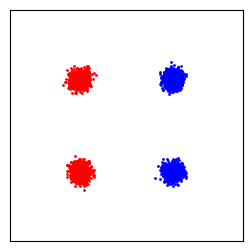

In [1]:
import torch
import matplotlib.pyplot as plt

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.toys_configs import Gauss_2_Gauss_MLP_FlowMatch as Configs

configs = Configs(DATA = '2Gauss',
                num_points = 1000,
                scale = 0.2,
                data_split_fracs = [1.0, 0.0, 0.0],
                batch_size = 64,
                EPOCHS = 200,
                lr = 1e-3,
                dim_hidden = 64, 
                dim_time_emb = 8,
                sigma = 0.001,
                solver='dopri5',
                num_sampling_steps=100  
               )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

#...dataset:

from DynGenModels.datamodules.toys.datasets import Gauss_2_Gauss_Dataset 

toys = Gauss_2_Gauss_Dataset(configs)

fig = plt.figure(figsize=(3, 3))
plt.scatter(toys.source[:,0], toys.source[:,1], s=1, c='r')
plt.scatter(toys.target[:,0], toys.target[:,1], s=1, c='b')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xticks([])
plt.yticks([])
plt.show()

In [2]:
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching, ConditionalFlowMatching


cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs), 
                         model = MLP(configs),
                         dataloader = ToysDataLoader(toys, configs), 
                         configs = configs)
cfm.train()

number of training parameters: 9154
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 2000, validation size: 0, testing sizes: 0


epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
pipeline = FlowMatchPipeline(trained_model=cfm, configs=configs)


X0 = torch.tensor([-2., 2.]) + configs.scale * torch.randn(configs.num_points, 2)
Y0 = torch.tensor([-2., -2.]) + configs.scale * torch.randn(configs.num_points, 2)
source = torch.cat([X0, Y0], dim=0)

pipeline.generate_samples(input_source=source)

INFO: neural ODE solver with dopri5 method and steps=100


  0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
import matplotlib.pyplot as plt

def plot_trajs(trajectories, num_sampling_steps=100):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    for i in range(num_sampling_steps): 
        plt.scatter(trajectories[i][:,0],trajectories[i][:,1], s=0.1, color='gray', alpha=0.2)
    plt.scatter(trajectories[0][:,0], trajectories[0][:,1], s=1, color='red')
    plt.scatter(trajectories[-1][:,0],trajectories[-1][:,1], s=1, color='blue')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

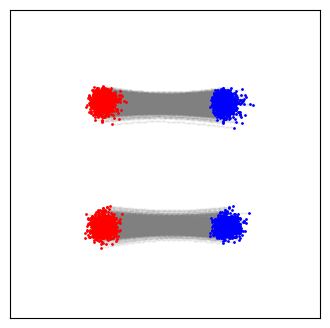

In [6]:
plot_trajs(pipeline.trajectories, num_sampling_steps=configs.num_sampling_steps)

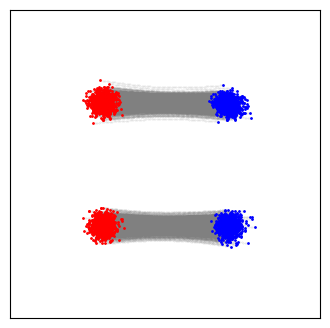

In [11]:
plot_trajs(pipeline.trajectories, num_sampling_steps=configs.num_sampling_steps)